In [1]:
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
from scipy import special, stats
import numpy as np
import seaborn as sns
from cycler import cycler
from patsy import bs, dmatrix
import calendar

4. (40) Bike sharing or rental systems have become popular in a number of
major cities throughout the world. A description of these systems and the
data set for this problem can be found here. These data consist of “hourly
and daily count of rental bikes between years 2011 and 2012 in Capital
bikeshare system with the corresponding weather and seasonal information.” Your goal is to aid the planning by the managers of these systems
by predicting the number of bike rentals with associated uncertainty for
January 2013. In developing these predictions you should use the hourly
data and provide the following components in your report.

(a) Exploration of the data through visual displays (at least one)

(b) Processing of the data for use in modeling - describe your steps in
performing this processing

(c) Modeling - show the Bayesian regression model and briefly describe
your choice for priors and their parameters

(d) Prior predictive checks

(e) Posterior checks and sampling evaluation

(f) Model evaluation

(g) Expected future bike rental counts by hour and day for January 2013
with uncertainty measures.

In [2]:
from google.colab import files
uploaded = files.upload()


Saving bikes_hour.csv to bikes_hour (1).csv


In [3]:
bike = pd.read_csv("bikes_hour.csv", parse_dates = ["dteday"])
bike = bike[::20] #since that data is huge and processing power is limited, we use every 20th row so it doesnt take too long to run
#multiples of 20 make it so that each hour of the day is still accounted for
import seaborn as sns
bike

,instant,dteday,season,yr,mnth,hour,holiday,weekday,workingday,weathersit,temperature,atemp,humidity,windspeed,casual,registered,count
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
20,21,2011-01-01,1,0,1,20,0,6,0,2,0.40,0.4091,0.87,0.2537,11,25,36
40,41,2011-01-02,1,0,1,17,0,0,0,1,0.34,0.3333,0.57,0.1940,7,58,65
60,61,2011-01-03,1,0,1,15,0,1,1,1,0.26,0.2424,0.30,0.2537,14,58,72
80,81,2011-01-04,1,0,1,12,0,2,1,1,0.22,0.2273,0.51,0.1642,12,66,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17280,17281,2012-12-27,1,1,12,21,0,4,1,2,0.24,0.2273,0.60,0.2537,12,51,63
17300,17301,2012-12-28,1,1,12,17,0,5,1,1,0.24,0.2424,0.60,0.1343,43,228,271
17320,17321,2012-12-29,1,1,12,13,0,6,0,3,0.20,0.2424,1.00,0.0000,13,71,84
17340,17341,2012-12-30,1,1,12,9,0,0,0,1,0.24,0.2121,0.52,0.3881,9,65,74


In [4]:
bike = bike.set_index("dteday") #setting data time as the index
date = pd.to_datetime("2012-12-01")
bike["pre"] = bike.index < date #tags each record based on whether it occurred before or on/after


<Axes: ylabel='count'>

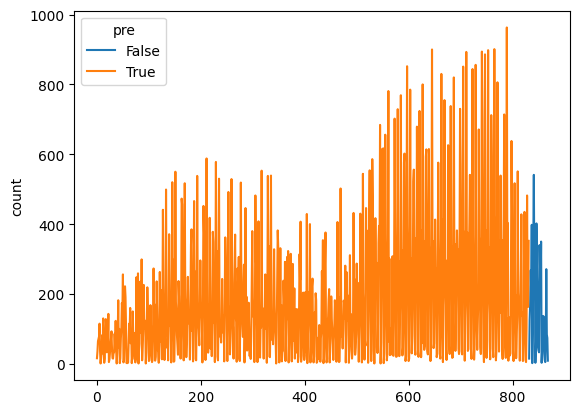

In [5]:
bike = bike.reset_index() #resetting the index for this plot
ax = sns.lineplot(data = bike, x= bike.index, y="count", hue="pre")
ax


In [6]:
bike = bike.set_index("dteday")
pre = bike[bike.index < date].reset_index()
post = bike[bike.index >= date].reset_index()

In [7]:
#Here, we scale the dates between 0 and 1 accordingly
t = (pre["dteday"] - pd.Timestamp("2011-01-01")).dt.days.to_numpy()
t_min = np.min(t)
t_max = np.max(t)
pre['time'] = (t - t_min) / (t_max - t_min)


In [8]:
t = (post["dteday"] - pd.Timestamp("2011-01-01")).dt.days.to_numpy()
t_min = np.min(t)
t_max = np.max(t)
post['time'] = (t - t_min) / (t_max - t_min)


In [9]:
# importing some functions I found to make the analysis more convenient
def ZeroSumNormal(name, *, sigma=None, active_dims=None, dims, model=None):
    model = pm.modelcontext(model=model)
    if isinstance(dims, str):
        dims = [dims]
    if isinstance(active_dims, str):
        active_dims = [active_dims]
    if active_dims is None:
        active_dims = dims[-1]
    def extend_axis(value, axis):
        n_out = value.shape[axis] + 1
        sum_vals = value.sum(axis, keepdims=True)
        norm = sum_vals / (pt.sqrt(n_out) + n_out)
        fill_val = norm - sum_vals / pt.sqrt(n_out)
        out = pt.concatenate([value, fill_val], axis=axis)
        return out - norm
    dims_reduced = []
    active_axes = []
    for i, dim in enumerate(dims):
        if dim in active_dims:
            active_axes.append(i)
            dim_name = f"{dim}_reduced"
            if name not in model.coords:
                model.add_coord(dim_name, length=len(model.coords[dim]) - 1, mutable=False)
            dims_reduced.append(dim_name)
        else:
            dims_reduced.append(dim)
    raw = pm.Normal(f"{name}_raw", sigma=sigma, dims=dims_reduced)
    for axis in active_axes:
        raw = extend_axis(raw, axis)
    return pm.Deterministic(name, raw, dims=dims)
def format_x_axis(ax, minor=False):
    # major ticks
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y %b"))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.grid(which="major", linestyle="-", axis="x")
    # minor ticks
    if minor:
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y %b"))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(which="minor", linestyle=":", axis="x")
    # rotate labels
    for label in ax.get_xticklabels(which="both"):
        label.set(rotation=70, horizontalalignment="right")
def plot_xY(x, Y, ax, label=''):
    quantiles = Y.quantile((0.025, 0.25, 0.5, 0.75, 0.975), dim=("chain", "draw")).transpose()
    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.025, 0.975]),
        fill_kwargs={"alpha": 0.25},
        smooth=False,
        ax=ax,
    )
    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.25, 0.75]),
        fill_kwargs={"alpha": 0.5},
        smooth=False,
               ax=ax,
    )
    ax.plot(x, quantiles.sel(quantile=0.5), color="C1", lw=3, label=label)
# default figure sizes
figsize = (10, 5)
# create a list of month strings, for plotting purposes
month_strings = calendar.month_name[1:]
hour1 = list(range(1, 25))


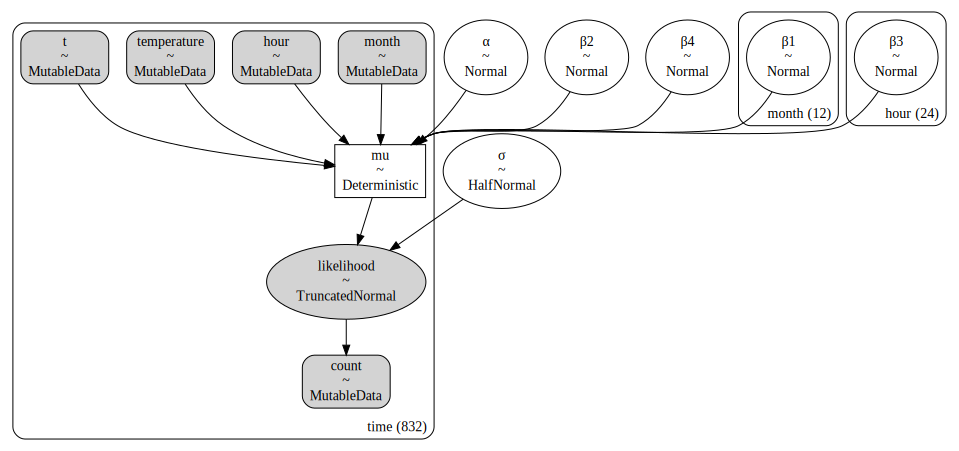

In [10]:
# regression model
with pm.Model(coords = {"month": month_strings, "hour": hour1}) as linear:

    month = pm.MutableData("month", pre["mnth"].to_numpy(), dims = "time")
    time = pm.MutableData("t", pre["time"], dims = "time")
    hour = pm.MutableData("hour", pre["hour"].to_numpy(), dims = "time")
    temp = pm.MutableData("temperature", pre["temperature"].to_numpy(), dims = "time")
    count = pm.MutableData("count", pre["count"].to_numpy(), dims = "time")
    α = pm.Normal("α", mu=192, sigma=50) #mean number of counts
    β1 = pm.Normal("β1", mu=0, sigma=50, dims = "month") #month
    β2 = pm.Normal("β2", mu=0, sigma=50) #time
    β3 = pm.Normal("β3", mu=0, sigma=50, dims = "hour") #hour
    β4 = pm.Normal("β4", mu=0, sigma=50) #temp
    mu = pm.Deterministic("mu", α + β1[month-1] + β2*time + β3[hour-1] + β4*temp, dims="time")
    #likelihood
    σ = pm.HalfNormal("σ", sigma=1000)
    pm.TruncatedNormal("likelihood", mu=mu, sigma=σ, observed=count, dims = "time") #count can not be below 0, no ne
pm.model_to_graphviz(linear)

In regards to my choice of priors, I've established priors for intercept and slopes using Normal distributions, indicating that the basal effects of these parameters (months, hours, and temperature) on bike rental counts are centered around zero but with considerable uncertainty (standard deviation of 50). The intercept's prior suggests an expected mean count of 192 rentals, with its own uncertainty (standard deviation of 50). For the likelihood of counts, I've chosen a Truncated Normal distribution with a large standard deviation of 1000 to account for positive count values only.

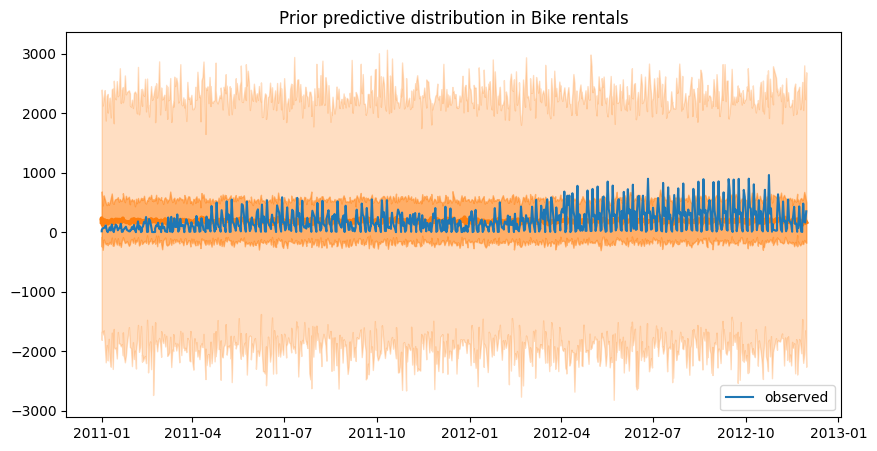

In [11]:
with linear:
    idata = pm.sample_prior_predictive()
fig, ax = plt.subplots(figsize=figsize)
plot_xY(pre["dteday"], idata.prior_predictive["likelihood"], ax)
ax.plot(pre["dteday"], pre["count"], label="observed")
ax.set(title="Prior predictive distribution in Bike rentals")
plt.legend();

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


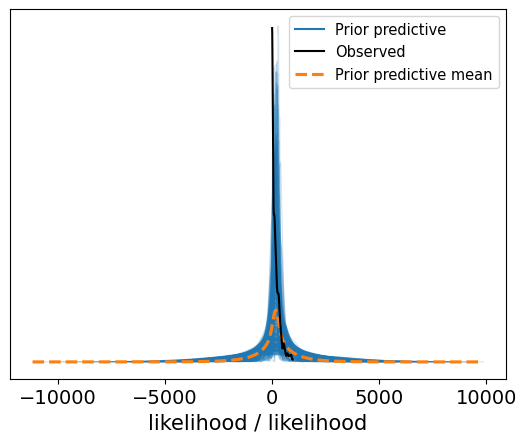

In [12]:
az.plot_ppc(idata, group="prior");


In [13]:
with linear:
  linear_trace = pm.sample(return_inferencedata = True)

array([[<Axes: title={'center': 'α'}>, <Axes: title={'center': 'α'}>],
       [<Axes: title={'center': 'β1'}>, <Axes: title={'center': 'β1'}>],
       [<Axes: title={'center': 'β2'}>, <Axes: title={'center': 'β2'}>],
       [<Axes: title={'center': 'β3'}>, <Axes: title={'center': 'β3'}>],
       [<Axes: title={'center': 'β4'}>, <Axes: title={'center': 'β4'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

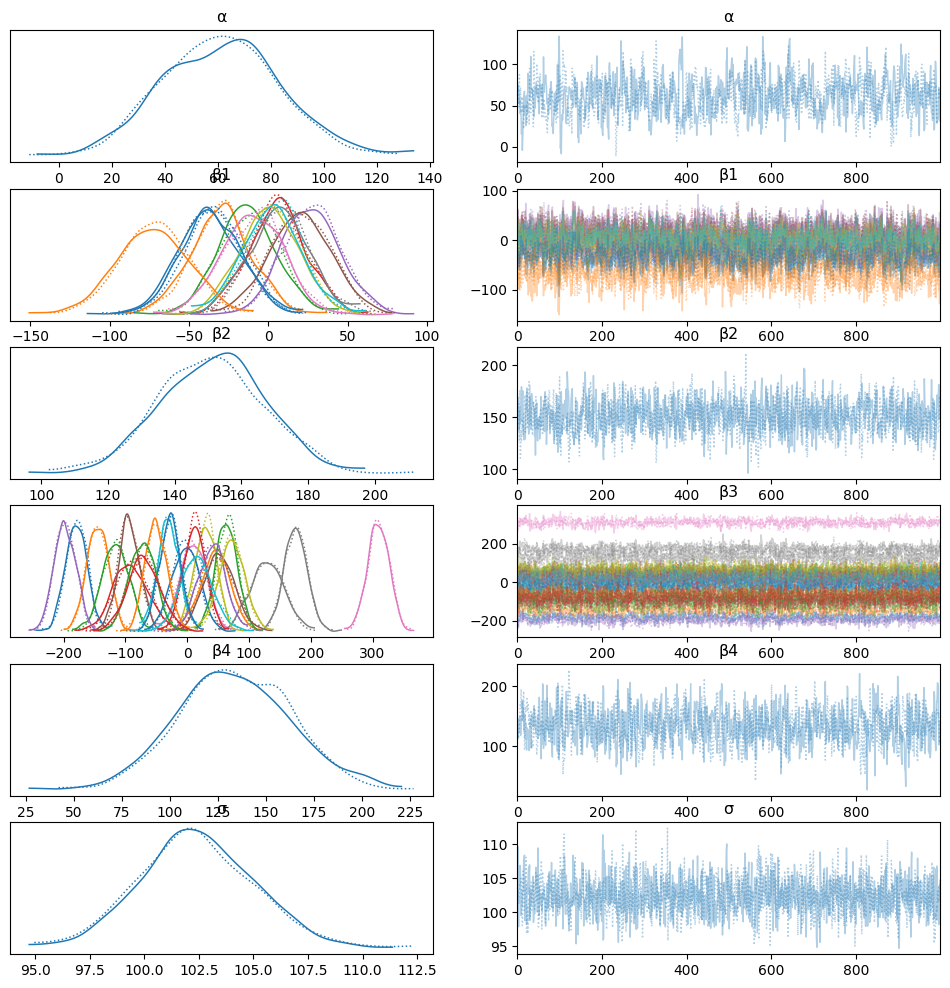

In [14]:
az.plot_trace(linear_trace, var_names = ["~mu"])

array([[<Axes: title={'center': 'α'}>,
        <Axes: title={'center': 'α'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'β1'}>,
        <Axes: title={'center': 'β1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'β2'}>,
        <Axes: title={'center': 'β2'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'β3'}>,
        <Axes: title={'center': 'β3'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'β4'}>,
        <Axes: title={'center': 'β4'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'σ'}>,
        <Axes: title={'center': 'σ'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

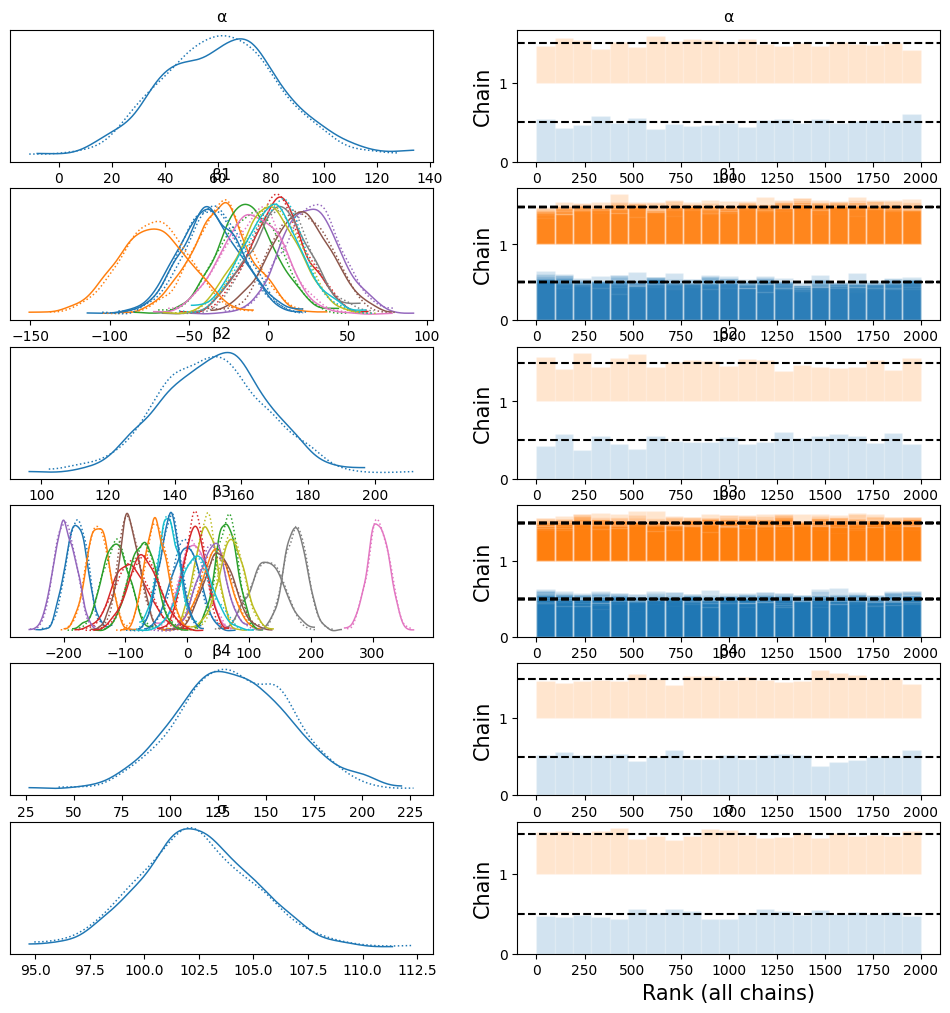

In [15]:
az.plot_trace(linear_trace, var_names = ["~mu"], kind = 'rank_bars')

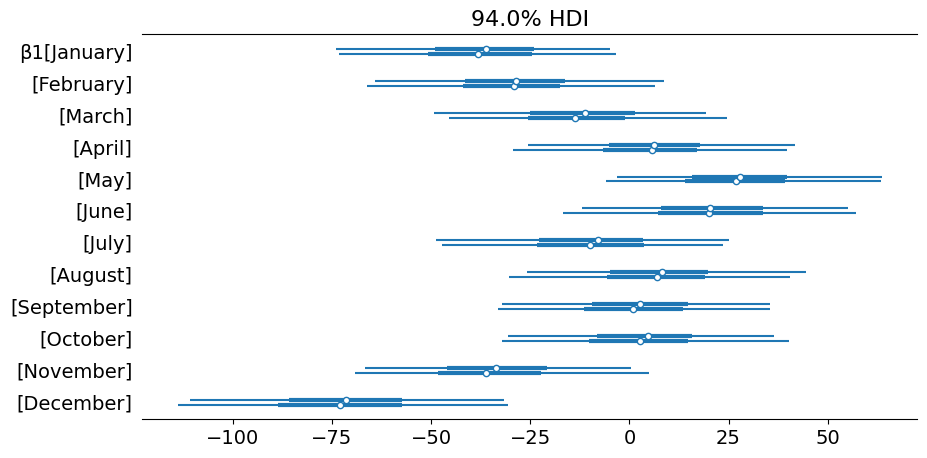

In [16]:
az.plot_forest(linear_trace.posterior, var_names=["β1"], figsize=figsize);

(e) Posterior checks

In [17]:

import matplotlib.dates as mdates



In [18]:
random_seed = 1234

with linear:
  idata.extend(pm.sample(random_seed=random_seed))



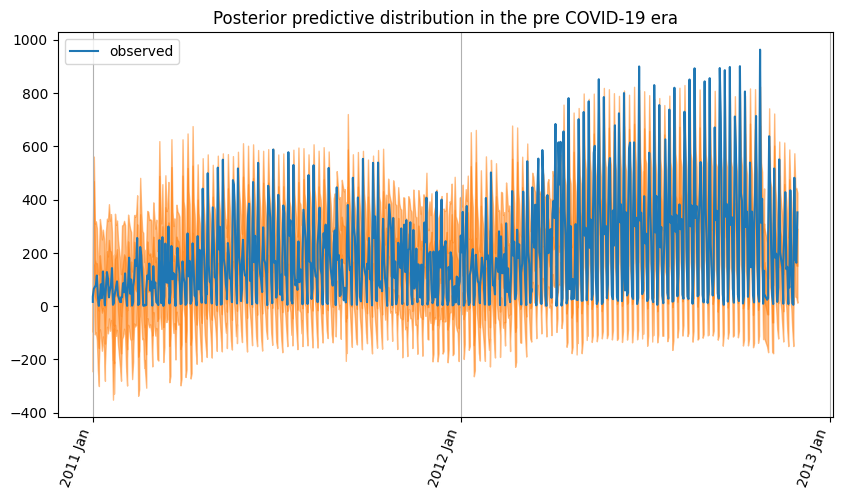

In [19]:
with linear:
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=random_seed))

fig, ax = plt.subplots(figsize=figsize)

az.plot_hdi(pre["dteday"], idata.posterior_predictive["likelihood"], hdi_prob=0.5, smooth=False)
az.plot_hdi(pre["dteday"], idata.posterior_predictive["likelihood"], hdi_prob=0.95, smooth=False)
ax.plot(pre['dteday'], pre["count"], label="observed")
format_x_axis(ax)
ax.set(title="Posterior predictive distribution in the pre COVID-19 era")
plt.legend();

In [20]:
# part 5
az.summary(linear_trace, var_names=['α','β1','β2','β3','β4','mu','σ',])



/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,61.316,22.097,19.751,100.407,0.987,0.699,503.0,879.0,1.01
β1[January],-37.303,19.084,-73.193,-3.263,0.807,0.571,563.0,919.0,1.01
β1[February],-29.537,19.262,-64.107,9.005,0.809,0.572,565.0,985.0,1.01
β1[March],-12.590,18.850,-46.316,23.235,0.773,0.547,594.0,914.0,1.01
β1[April],5.858,18.169,-28.588,39.602,0.735,0.520,612.0,957.0,1.01
...,...,...,...,...,...,...,...,...,...
mu[828],387.403,20.299,350.817,425.167,0.424,0.303,2288.0,1689.0,1.00
mu[829],237.320,19.187,201.502,272.070,0.399,0.282,2311.0,1497.0,1.00
mu[830],222.768,22.550,181.103,264.965,0.474,0.335,2263.0,1749.0,1.00
mu[831],216.833,22.648,170.622,256.995,0.473,0.339,2297.0,1447.0,1.00


In [21]:
bike

,instant,season,yr,mnth,hour,holiday,weekday,workingday,weathersit,temperature,atemp,humidity,windspeed,casual,registered,count,pre
dteday,,,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16,True
2011-01-01,21,1,0,1,20,0,6,0,2,0.40,0.4091,0.87,0.2537,11,25,36,True
2011-01-02,41,1,0,1,17,0,0,0,1,0.34,0.3333,0.57,0.1940,7,58,65,True
2011-01-03,61,1,0,1,15,0,1,1,1,0.26,0.2424,0.30,0.2537,14,58,72,True
2011-01-04,81,1,0,1,12,0,2,1,1,0.22,0.2273,0.51,0.1642,12,66,78,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-27,17281,1,1,12,21,0,4,1,2,0.24,0.2273,0.60,0.2537,12,51,63,False
2012-12-28,17301,1,1,12,17,0,5,1,1,0.24,0.2424,0.60,0.1343,43,228,271,False
2012-12-29,17321,1,1,12,13,0,6,0,3,0.20,0.2424,1.00,0.0000,13,71,84,False


In [25]:
# g) Expected future bike rental counts by hour and day for January 2013 with uncertainty measures.

with linear:
    pm.set_data(
        {
            "month": post["mnth"].to_numpy(),
            'hour':post['hour'].to_numpy(),
            "t": post["time"].to_numpy(),
            "temperature": post["temperature"].to_numpy(),
        }
    )
    counterfactual = pm.sample_posterior_predictive(
        idata, var_names=["likelihood"], random_seed=random_seed
    )





In [ ]:
  # regression model
with pm.Model(coords = {"month": month_strings, "hour": hour1}) as linear:

    month = pm.MutableData("month", pre["mnth"].to_numpy(), dims = "time")
    time = pm.MutableData("t", pre["time"], dims = "time")
    hour = pm.MutableData("hour", pre["hour"].to_numpy(), dims = "time")
    temp = pm.MutableData("temperature", pre["temperature"].to_numpy(), dims = "time")
    count = pm.MutableData("count", pre["count"].to_numpy(), dims = "time")
    α = pm.Normal("α", mu=192, sigma=50) #mean number of counts
    β1 = pm.Normal("β1", mu=0, sigma=50, dims = "month") #month
    β2 = pm.Normal("β2", mu=0, sigma=50) #time
    β3 = pm.Normal("β3", mu=0, sigma=50, dims = "hour") #hour
    β4 = pm.Normal("β4", mu=0, sigma=50) #temp
    mu = pm.Deterministic("mu", α + β1[month-1] + β2*time + β3[hour-1] + β4*temp, dims="time")
    #likelihood
    σ = pm.HalfNormal("σ", sigma=1000)
    pm.TruncatedNormal("likelihood", mu=mu, sigma=σ, observed=count, dims = "time") #count can not be below 0, no ne
pm.model_to_graphviz(linear)

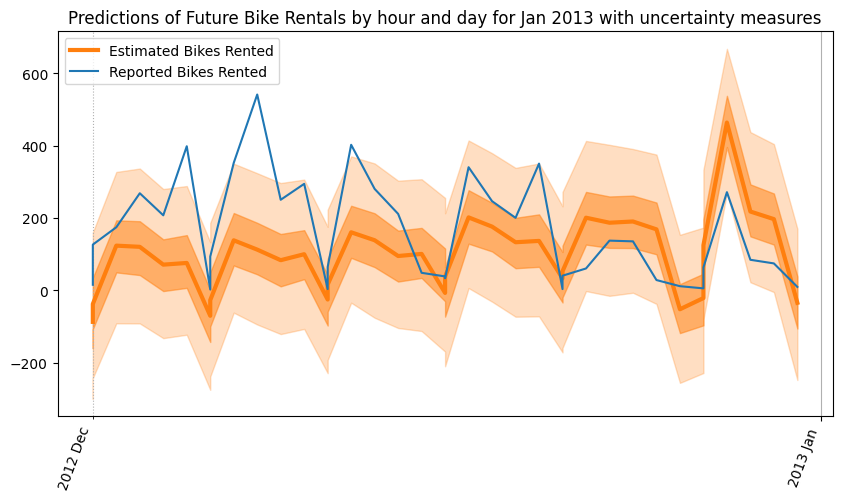

In [29]:
fig, ax = plt.subplots(figsize=figsize)

plot_xY(post['dteday'], counterfactual.posterior_predictive["likelihood"], ax, label='Estimated Bikes Rented')
format_x_axis(ax, minor=True)
ax.plot(post['dteday'], post["count"], label="Reported Bikes Rented")
ax.set(title="Predictions of Future Bike Rentals by hour and day for Jan 2013 with uncertainty measures")
plt.legend();